# Vehicle Counting
## Detection using OpenCV & Python

### We’ll use the YOLOv3 model with OpenCV-python. Open-CV is a real-time computer vision library of Python. We can use YOLO directly with OpenCV.

#### We will detect and classify vehicle on road in the video and and classify them as car ,trucks buses and keep the count of them and storing the data in csv file.

# 1. Making Tracker

### The tracker basically uses the Euclidean_distance concept to keep track of an object. It calculates the difference between two center points of an object in the current frame vs the previous frame, and if the distance is less than the threshold distance then it confirms that the object is the same object of the previous frame.

In [1]:
import math

class EuclideanDistTracker:
    def __init__(self):
        # Store the center positions of the objects
        self.center_points = {}
        # Keep the count of the IDs
        # each time a new object id detected, the count will increase by one
        self.id_count = 0


    def update(self, objects_rect):
        # Objects boxes and ids
        objects_bbs_ids = []

        # Get center point of new object
        for rect in objects_rect:
            x, y, w, h, index = rect
            cx = (x + x + w) // 2
            cy = (y + y + h) // 2

            # Find out if that object was detected already
            same_object_detected = False
            for id, pt in self.center_points.items():
                dist = math.hypot(cx - pt[0], cy - pt[1])

                if dist < 25:
                    self.center_points[id] = (cx, cy)
                    # print(self.center_points)
                    objects_bbs_ids.append([x, y, w, h, id, index])
                    same_object_detected = True
                    break

            # New object is detected we assign the ID to that object
            if same_object_detected is False:
                self.center_points[self.id_count] = (cx, cy)
                objects_bbs_ids.append([x, y, w, h, self.id_count, index])
                self.id_count += 1

        # Clean the dictionary by center points to remove IDS not used anymore
        new_center_points = {}
        for obj_bb_id in objects_bbs_ids:
            _, _, _, _, object_id, index = obj_bb_id
            center = self.center_points[object_id]
            new_center_points[object_id] = center

        # Update dictionary with IDs not used removed
        self.center_points = new_center_points.copy()
        return objects_bbs_ids



def ad(a, b):
    return a+b

In [2]:
import cv2
import csv
import collections
import numpy as np
import argparse
import imutils

In [3]:
# Initialize Tracker
tracker = EuclideanDistTracker()

In [4]:
# Initialize the videocapture object
cap = cv2.VideoCapture('video.mp4')
input_size = 320

In [5]:
# Detection confidence threshold
confThreshold =0.2
nmsThreshold= 0.2

font_color = (0, 0, 255)
font_size = 0.5
font_thickness = 2

# Middle cross line position
middle_line_position = 225   
up_line_position = middle_line_position - 15
down_line_position = middle_line_position + 15

In [6]:
# Store Coco Names in a list
classesFile = "coco.names"
classNames = open(classesFile).read().strip().split('\n')
print(classNames)
print(len(classNames))

# class index for our required detection classes
required_class_index = [2, 3, 5, 7]

detected_classNames = []


['person', 'bicycle', 'car', 'motorbike', 'aeroplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'sofa', 'pottedplant', 'bed', 'diningtable', 'toilet', 'tvmonitor', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']
80


In [7]:
## Model Files
modelConfiguration = 'yolov3-320.cfg'
modelWeigheights = 'yolov3-320.weights'

# configure the network model
net = cv2.dnn.readNetFromDarknet(modelConfiguration, modelWeigheights)

# Configure the network backend

net.setPreferableBackend(cv2.dnn.DNN_BACKEND_CUDA)
net.setPreferableTarget(cv2.dnn.DNN_TARGET_CUDA)

# Define random colour for each class
np.random.seed(42)
colors = np.random.randint(0, 255, size=(len(classNames), 3), dtype='uint8')

In [8]:
# Function for finding the center of a rectangle
def find_center(x, y, w, h):
    x1=int(w/2)
    y1=int(h/2)
    cx = x+x1
    cy=y+y1
    return cx, cy

In [9]:
# List for store vehicle count information
temp_up_list = []
temp_down_list = []
up_list = [0, 0, 0, 0]
down_list = [0, 0, 0, 0]

In [10]:
# Function for count vehicle
def count_vehicle(box_id, img):

    x, y, w, h, id, index = box_id

    # Find the center of the rectangle for detection
    center = find_center(x, y, w, h)
    ix, iy = center
    
    # Find the current position of the vehicle
    if (iy > up_line_position) and (iy < middle_line_position):

        if id not in temp_up_list:
            temp_up_list.append(id)

    elif iy < down_line_position and iy > middle_line_position:
        if id not in temp_down_list:
            temp_down_list.append(id)
            
    elif iy < up_line_position:
        if id in temp_down_list:
            temp_down_list.remove(id)
            up_list[index] = up_list[index]+1

    elif iy > down_line_position:
        if id in temp_up_list:
            temp_up_list.remove(id)
            down_list[index] = down_list[index] + 1

    # Draw circle in the middle of the rectangle
    cv2.circle(img, center, 2, (0, 0, 255), -1)  # end here
    # print(up_list, down_list)

In [11]:
# Function for finding the detected objects from the network output
def postProcess(outputs,img):
    global detected_classNames 
    height, width = img.shape[:2]
    boxes = []
    classIds = []
    confidence_scores = []
    detection = []
    for output in outputs:
        for det in output:
            scores = det[5:]
            classId = np.argmax(scores)
            confidence = scores[classId]
            if classId in required_class_index:
                if confidence > confThreshold:
                    # print(classId)
                    w,h = int(det[2]*width) , int(det[3]*height)
                    x,y = int((det[0]*width)-w/2) , int((det[1]*height)-h/2)
                    boxes.append([x,y,w,h])
                    classIds.append(classId)
                    confidence_scores.append(float(confidence))

    # Apply Non-Max Suppression
    indices = cv2.dnn.NMSBoxes(boxes, confidence_scores, confThreshold, nmsThreshold)
    # print(classIds)
    for i in indices.flatten():
        x, y, w, h = boxes[i][0], boxes[i][1], boxes[i][2], boxes[i][3]
        # print(x,y,w,h)

        color = [int(c) for c in colors[classIds[i]]]
        name = classNames[classIds[i]]
        detected_classNames.append(name)
        # Draw classname and confidence score 
        cv2.putText(img,f'{name.upper()} {int(confidence_scores[i]*100)}%',
                  (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)

        # Draw bounding rectangle
        cv2.rectangle(img, (x, y), (x + w, y + h), color, 1)
        detection.append([x, y, w, h, required_class_index.index(classIds[i])])

    # Update the tracker for each object
    boxes_ids = tracker.update(detection)
    for box_id in boxes_ids:
        count_vehicle(box_id, img)

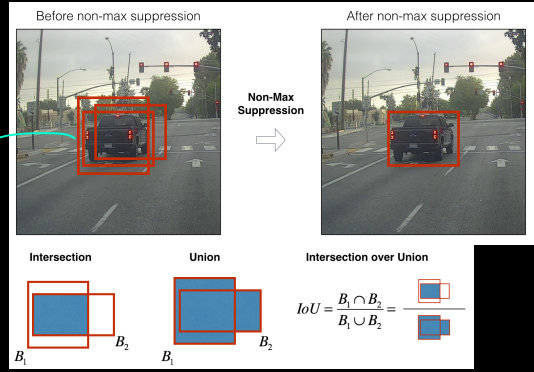

In [20]:
writer = None
(W, H) = (None, None)
# try to determine the total number of frames in the video file
try:
	prop = cv2.cv.CV_CAP_PROP_FRAME_COUNT if imutils.is_cv2() \
		else cv2.CAP_PROP_FRAME_COUNT
	total = int(vs.get(prop))
	print("[INFO] {} total frames in video".format(total))
# an error occurred while trying to determine the total
# number of frames in the video file
except:
	print("[INFO] could not determine # of frames in video")
	print("[INFO] no approx. completion time can be provided")
	total = -1
     

[INFO] could not determine # of frames in video
[INFO] no approx. completion time can be provided


In [13]:
'''def realTime():
    (W, H) = (None, None)
    while True:
        
        # read the next frame from the file
        (grabbed, img) = cap.read()

        if not grabbed:
            break
            # if the frame dimensions are empty, grab them
        if W is None or H is None:
            (H, W) = img.shape[:2]
        img = cv2.resize(img,(0,0),None,0.5,0.5)
        ih, iw, channels = img.shape
         # Draw the crossing lines
        cv2.line(img, (0, middle_line_position), (iw, middle_line_position),(255, 0, 255), 1)
        cv2.line(img, (0, up_line_position), (iw, up_line_position), (0, 0, 255), 1)
        cv2.line(img, (0, down_line_position), (iw, down_line_position), (0, 0, 255), 1)
        # Show the frames
        cv2.imshow('Output', img)
        

SyntaxError: EOF while scanning triple-quoted string literal (<ipython-input-13-4604cb585e66>, line 21)

In [14]:
def realTime():
    (W, H) = (None, None)
    while True:
        (grabbed, img) = cap.read()

        if not grabbed:
            break
            # if the frame dimensions are empty, grab them
        if W is None or H is None:
            (H, W) = img.shape[:2]
        img = cv2.resize(img,(0,0),None,0.5,0.5)
        ih, iw, channels = img.shape
        blob = cv2.dnn.blobFromImage(img, 1 / 255, (input_size, input_size), [0, 0, 0], 1, crop=False)

        # Set the input of the network
        net.setInput(blob)
        layersNames = net.getLayerNames()
        outputNames = [(layersNames[i - 1]) for i in net.getUnconnectedOutLayers()]
        # Feed data to the network
        outputs = net.forward(outputNames)
    
        # Find the objects from the network output
        postProcess(outputs,img)

        # Draw the crossing lines

        cv2.line(img, (0, middle_line_position), (iw, middle_line_position), (255, 0, 255), 2)
        cv2.line(img, (0, up_line_position), (iw, up_line_position), (0, 0, 255), 2)
        cv2.line(img, (0, down_line_position), (iw, down_line_position), (0, 0, 255), 2)

        # Draw counting texts in the frame
        cv2.putText(img, "Up", (110, 20), cv2.FONT_HERSHEY_SIMPLEX, font_size, font_color, font_thickness)
        cv2.putText(img, "Down", (160, 20), cv2.FONT_HERSHEY_SIMPLEX, font_size, font_color, font_thickness)
        cv2.putText(img, "Car:        "+str(up_list[0])+"     "+ str(down_list[0]), (20, 40), cv2.FONT_HERSHEY_SIMPLEX, font_size, font_color, font_thickness)
        cv2.putText(img, "Motorbike:  "+str(up_list[1])+"     "+ str(down_list[1]), (20, 60), cv2.FONT_HERSHEY_SIMPLEX, font_size, font_color, font_thickness)
        cv2.putText(img, "Bus:        "+str(up_list[2])+"     "+ str(down_list[2]), (20, 80), cv2.FONT_HERSHEY_SIMPLEX, font_size, font_color, font_thickness)
        cv2.putText(img, "Truck:      "+str(up_list[3])+"     "+ str(down_list[3]), (20, 100), cv2.FONT_HERSHEY_SIMPLEX, font_size, font_color, font_thickness)

        # Show the frames
        cv2.imshow('Output', img)

        if cv2.waitKey(1) == ord('q'):
            break

    # Write the vehicle counting information in a file and save it

    with open("data1.csv", 'w') as f1:
        cwriter = csv.writer(f1)
        cwriter.writerow(['Direction', 'car', 'motorbike', 'bus', 'truck'])
        up_list.insert(0, "Up")
        down_list.insert(0, "Down")
        cwriter.writerow(up_list)
        cwriter.writerow(down_list)
    f1.close()
    # print("Data saved at 'data.csv'")
    # Finally realese the capture object and destroy all active windows
    cap.release()
    cv2.destroyAllWindows()

In [15]:
if __name__ == '__main__':
          realTime()

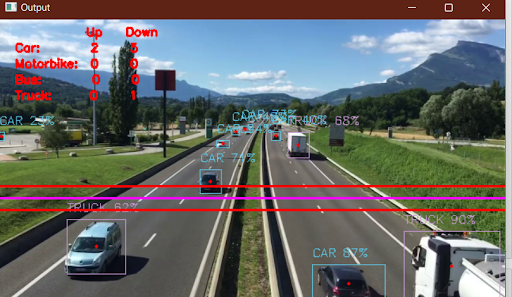